In [1]:
import sys
sys.path.append('C:\Python311\Lib\site-packages')
sys.path.append("C:\\Users\\souvik\\anaconda3\\envs\\sit_796_env\\Lib\\site-packages")
sys.path.append("C:\\Users\\souvik\\anaconda3\\pkgs")

In [36]:
import gym
import numpy as np
from tiles3 import IHT, tiles
import matplotlib.pyplot as plt

In [4]:
pendulumEnv = gym.make('Pendulum-v0')

In [5]:
def print_episodes(episode, episodic_rewards):
    print("Episode Num:", episode, "Avg. 100 episodic rewards:", np.mean(episodic_rewards[-100:])) 

### Semi-Gradient Sarsa(0) for Pendulum-v0

In [6]:
class PendulumEnvTileForSarsa0():
    
    def __init__(self, state_space, action_space, num_tilings, num_tiles):
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.num_state_dims = len(state_space.low)
        self.maximum_tiles = (self.num_tilings + 1)**self.num_state_dims * self.num_tilings * len(action_space)        
        self.iht = IHT(self.maximum_tiles)  
        self.state_space_scales = self.num_tilings / (state_space.high - state_space.low)
        
    def get_maximum_tiles(self):
        return self.maximum_tiles
    
    def get_number_tilings(self):
        return self.num_tilings
    
    def get_features(self, state, action):
        scaled_state = np.multiply(self.state_space_scales, state)
        features = tiles(self.iht, self.num_tilings, scaled_state, [action])
        return np.array(features)

In [7]:
class PendulumStateActionEstimator():

    def __init__(self, step_size, action_space, env_tile):  
        self.env_tile = env_tile
        self.action_space = action_space
        self.alpha = step_size/self.env_tile.get_number_tilings()
        self.weights = np.zeros(self.env_tile.get_maximum_tiles())
    

    def update_weights(self, state, action, target):
        features = self.env_tile.get_features(state, action)
        estimated_value = np.sum(self.weights[features])
        td_error = (target - estimated_value)
        self.weights[features] += self.alpha * td_error

    def estimate_value(self, state, action):
        features = self.env_tile.get_features(state, action)
        estimated_value = np.sum(self.weights[features])
        return estimated_value      

    def get_greedy_action(self, state):
        values = []
        for a in self.action_space:
            estimated_next_state_value = self.estimate_value(state, a)
            values.append(estimated_next_state_value)
        
        values = np.array(values)
        best_action_idx = np.argmax(np.random.random(values.shape) * (values==values.max()))
        action = self.action_space[best_action_idx]
        return action

    def get_epsilon_greedy_action(self, state, epsilon):
        random_value = np.random.random()
        if random_value < 1 - epsilon:
            action = self.get_greedy_action(state)
        else:
            action = np.random.choice(self.action_space)
        return action

In [8]:
def semi_gradient_sarsa_0(env, estimator, config):
    
    epsilon = config["eps_start"]
    episodic_rewards = []

    for episode in range(config["num_episodes"]):
        state = env.reset()
        action = estimator.get_epsilon_greedy_action(state, epsilon)
        episode_rewards = 0
        done = False

        while not done:
            next_state, reward, done, _ = env.step([action])

            if done:
                estimator.update_weights(state, action, reward)

            else:
                next_action = estimator.get_epsilon_greedy_action(next_state, epsilon)        
                next_step_estimated_value = estimator.estimate_value(next_state, next_action)
                target = reward + config["gamma"] * next_step_estimated_value
                estimator.update_weights(state, action, target)

                state = next_state
                action = next_action
                episode_rewards += reward      

        epsilon = max(epsilon * config["eps_decay"], config["eps_end"])
        episodic_rewards.append(episode_rewards)
        
        if episode % 100 == 0:
            print_episodes(episode, episodic_rewards)   

  
    return episodic_rewards

In [13]:
def exec_sg_sarsa0(env):
    process_config = {"gamma": 0.9999, 
                      "eps_start": 0.1, 
                      "eps_end": 0,  
                      "eps_decay": 0.999, 
                      "num_episodes": 2500}
    
    num_tilings = 12
    num_tiles = 8
    action_space = np.linspace(-2.0, 2.0, 5).astype(float)
    state_space = env.observation_space
    penv_tiler = PendulumEnvTileForSarsa0(state_space, action_space, num_tilings, num_tiles)
    
    step_size = 0.4
    state_action_estimator = PendulumStateActionEstimator(step_size, action_space, penv_tiler)
    episodic_rewards = semi_gradient_sarsa_0(env, state_action_estimator, process_config)
    
    return episodic_rewards

In [14]:
episodic_rewards_sarsa0 = exec_sg_sarsa0(pendulumEnv)

Episode Num: 0 Avg. 100 episodic rewards: -952.223630083892
Episode Num: 100 Avg. 100 episodic rewards: -1184.0200052863856
Episode Num: 200 Avg. 100 episodic rewards: -933.9960818541116
Episode Num: 300 Avg. 100 episodic rewards: -578.1765195212524
Episode Num: 400 Avg. 100 episodic rewards: -422.1189473000584
Episode Num: 500 Avg. 100 episodic rewards: -369.43756198181217
Episode Num: 600 Avg. 100 episodic rewards: -285.5755433179
Episode Num: 700 Avg. 100 episodic rewards: -253.68369440576924
Episode Num: 800 Avg. 100 episodic rewards: -267.2604828887108
Episode Num: 900 Avg. 100 episodic rewards: -194.73824503702966
Episode Num: 1000 Avg. 100 episodic rewards: -212.59353167084976
Episode Num: 1100 Avg. 100 episodic rewards: -229.64709836414713
Episode Num: 1200 Avg. 100 episodic rewards: -217.38662096252756
Episode Num: 1300 Avg. 100 episodic rewards: -166.83540309045642
Episode Num: 1400 Avg. 100 episodic rewards: -179.93511764738548
Episode Num: 1500 Avg. 100 episodic rewards: -1

In [15]:
print("Average episodic rewards over last 100 episodes:", np.mean(episodic_rewards_sarsa0[-100:]))

Average episodic rewards over last 100 episodes: -157.022168416461


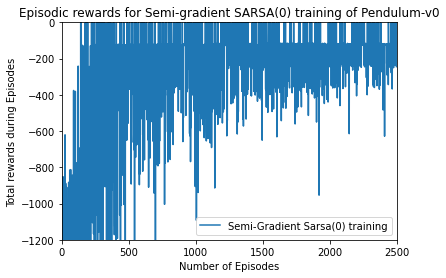

In [40]:
plt.plot(np.arange(2500), episodic_rewards_sarsa0[-2500:], label='Semi-Gradient Sarsa(0) training')
plt.ylim(-1200, 0)
plt.xlim(0, 2500)
plt.xlabel('Number of Episodes')
plt.ylabel('Total rewards during Episodes')
plt.title('Episodic rewards for Semi-gradient SARSA(0) training of Pendulum-v0')
plt.legend()
plt.show()



Episodic SG Sarsa(0) for Pendulum-v0
Avg. reward per episode over last 100 episodes: -157.022168416461


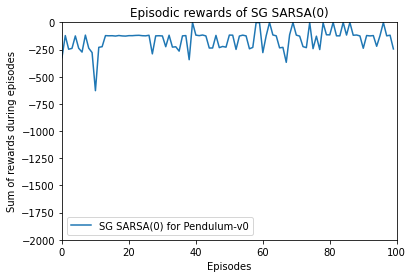

In [41]:
plt.plot(np.arange(100), episodic_rewards_sarsa0[-100:], label='SG SARSA(0) for Pendulum-v0')
plt.ylim(-2000, 0)
plt.xlim(0, 100)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episodes')
plt.title('Episodic rewards of SG SARSA(0)')
plt.legend()

print("")
print("\nEpisodic SG Sarsa(0) for Pendulum-v0")
print("Avg. reward per episode over last", 100, "episodes:", np.mean(episodic_rewards_sarsa0[-100:]))

### Semi-Gradient TD(lambda) for Pendulum-v0

In [16]:
class PendulumEnvTileForTDLambda():
    
    def __init__(self, state_space, num_tilings, num_tiles):
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.num_state_dims = len(state_space.low)
        self.maximum_tiles = (self.num_tilings + 1)**self.num_state_dims * self.num_tilings        
        self.iht = IHT(self.maximum_tiles)  
        self.state_space_scales = self.num_tilings / (state_space.high - state_space.low)
        
    def get_maximum_tiles(self):
        return self.maximum_tiles
    
    def get_number_tilings(self):
        return self.num_tilings
    
    def get_features(self, state):
        scaled_state = np.multiply(self.state_space_scales, state)
        features = tiles(self.iht, self.num_tilings, scaled_state)
        return np.array(features)

In [17]:
class PendulumStateValueEstimator():

    def __init__(self, step_size, env_tile):  
        self.env_tile = env_tile
        self.alpha = step_size/self.env_tile.get_number_tilings()
        self.weights = np.zeros(self.env_tile.get_maximum_tiles())
        self.eligibility_traces = np.zeros(self.env_tile.maximum_tiles)

    def update_weights(self, state, target):
        features = self.env_tile.get_features(state)
        estimated_value = np.sum(self.weights[features])
        td_error = (target - estimated_value)
        self.eligibility_traces[features] = 1
        self.weights[features] += self.alpha * td_error * self.eligibility_traces[features]

    def estimate_value(self, state):
        features = self.env_tile.get_features(state)
        estimated_value = np.sum(self.weights[features])
        return estimated_value
    
    def reset_eligibility_traces(self):       
        self.eligibility_traces = np.zeros(self.env_tile.get_maximum_tiles())

In [30]:
def semi_gradient_td_lambda(env, estimator, config, policy):
    
    epsilon = config["eps_start"]
    episodic_rewards = []
    
    for episode in range(config["num_episodes"]):
        
        state = env.reset()
        action = policy.get_greedy_action(state)
        estimator.reset_eligibility_traces()
        episode_rewards = 0
        done = False

        while not done:

            next_state, reward, done, _ = env.step([action])

            if done:
                estimator.update_weights(state, reward)
            
            else:
                next_action = policy.get_greedy_action(next_state)        
                next_step_estimated_value = estimator.estimate_value(next_state)
                target = reward + config["gamma"] * next_step_estimated_value
                estimator.update_weights(state, target)
                
                state = next_state
                action = next_action
                episode_rewards += reward

        epsilon = max(epsilon * config["eps_decay"], config["eps_end"])
        episodic_rewards.append(episode_rewards)
        
        if episode % 100 == 0:
            print_episodes(episode, episodic_rewards)
  
    return episodic_rewards

In [24]:
class TDLambdaActionPolicy():
    def __init__(self, action_space):
        self.action_space = action_space

    def get_greedy_action(self, state, epsilon=0):
        action = np.random.choice(self.action_space)
        return action

In [31]:
def exec_sg_td_lambda(env):
    process_config = {"gamma": 0.9999, 
                      "eps_start": 0.1, 
                      "eps_end": 0,  
                      "eps_decay": 0.999, 
                      "num_episodes": 2500}
    
    num_tilings = 12
    num_tiles = 8
    state_space = env.observation_space
    penv_tiler = PendulumEnvTileForTDLambda(state_space, num_tilings, num_tiles)
    
    step_size = 0.5
    state_value_estimator = PendulumStateValueEstimator(step_size, penv_tiler)
    
    action_space = np.linspace(-2.0, 2.0, 5).astype(float)
    policy = TDLambdaActionPolicy(action_space)
    episodic_rewards = semi_gradient_td_lambda(env, state_value_estimator, process_config, policy)
    
    return episodic_rewards

In [32]:
episodic_rewards_tdl = exec_sg_td_lambda(pendulumEnv)

Episode Num: 0 Avg. 100 episodic rewards: -901.1100665242966
Episode Num: 100 Avg. 100 episodic rewards: -1219.5512843565234
Episode Num: 200 Avg. 100 episodic rewards: -1235.8916735336759
Episode Num: 300 Avg. 100 episodic rewards: -1213.0607763989021
Episode Num: 400 Avg. 100 episodic rewards: -1202.8134621578427
Episode Num: 500 Avg. 100 episodic rewards: -1301.0551845680136
Episode Num: 600 Avg. 100 episodic rewards: -1218.4875564084095
Episode Num: 700 Avg. 100 episodic rewards: -1190.3089421994582
Episode Num: 800 Avg. 100 episodic rewards: -1241.899361916535
Episode Num: 900 Avg. 100 episodic rewards: -1218.0535499573004
Episode Num: 1000 Avg. 100 episodic rewards: -1209.6367669459207
Episode Num: 1100 Avg. 100 episodic rewards: -1215.9593028412198
Episode Num: 1200 Avg. 100 episodic rewards: -1203.866977153145
Episode Num: 1300 Avg. 100 episodic rewards: -1243.6252785610354
Episode Num: 1400 Avg. 100 episodic rewards: -1222.932457510701
Episode Num: 1500 Avg. 100 episodic rewar

In [33]:
print("Average episodic rewards over last 100 episodes:", np.mean(episodic_rewards_tdl[-100:]))

Average episodic rewards over last 100 episodes: -1201.8655244868812


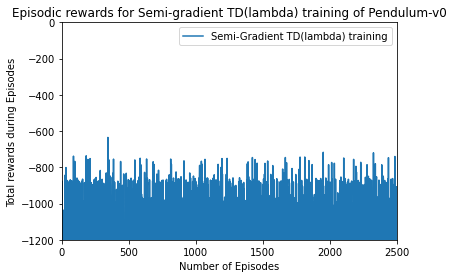

In [43]:
plt.plot(np.arange(2500), episodic_rewards_tdl[-2500:], label='Semi-Gradient TD(lambda) training')
plt.ylim(-1200, 0)
plt.xlim(0, 2500)
plt.xlabel('Number of Episodes')
plt.ylabel('Total rewards during Episodes')
plt.title('Episodic rewards for Semi-gradient TD(lambda) training of Pendulum-v0')
plt.legend()
plt.show()



Episodic SG TD(lambda) for Pendulum-v0
Avg. reward per episode over last 100 episodes: -1201.8655244868812


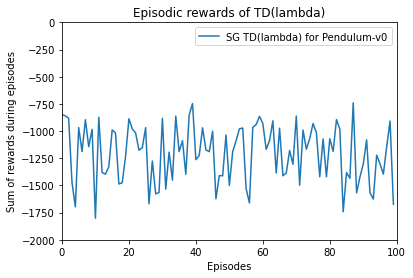

In [44]:
plt.plot(np.arange(100), episodic_rewards_tdl[-100:], label='SG TD(lambda) for Pendulum-v0')
plt.ylim(-2000, 0)
plt.xlim(0, 100)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episodes')
plt.title('Episodic rewards of TD(lambda)')
plt.legend()

print("")
print("\nEpisodic SG TD(lambda) for Pendulum-v0")
print("Avg. reward per episode over last", 100, "episodes:", np.mean(episodic_rewards_tdl[-100:]))